### Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import math
import datetime
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [2]:
import xgboost as xgb
from xgboost import plot_tree

### Reading in the train, test and submission files

In [3]:
train = pd.read_csv('Train(1).csv')
test = pd.read_csv('Test(1).csv')
sub = pd.read_csv('SampleSubmission(1).csv')

In [4]:
Train = train.copy()
Train = Train.set_index(['Applicant_ID'])
Train.head()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,...,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
Applicant_ID,,,,,,,,,,,,,,,,,,,,,
Apcnt_1000000,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,11333126.0,...,0.392854,2.02,0.711632,0.0,0.0,charge,NaN,1.129518,0.044335,no
Apcnt_1000004,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,2533168.0,...,0.314281,8.08,0.183584,NaN,0.0,charge,349.805730,1.620483,0.322436,no
Apcnt_1000008,3276.0,0.53845,3.1510,0.0,6.282,NaN,956940.0,NaN,192944.0,1079864.0,...,0.162965,18.18,0.791136,0.0,0.0,charge,NaN,1.513370,0.011640,yes
Apcnt_1000012,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,3621979.0,...,0.488884,2.02,0.685168,NaN,0.0,charge,89.940100,0.664452,0.082729,no
Apcnt_1000016,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,361770.0,...,0.275000,12.12,0.438168,0.0,0.0,charge,97.887502,1.427891,0.045630,no


### Understanding the data set(train and test)

In [5]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56000 entries, Apcnt_1000000 to Apcnt_999996
Data columns (total 51 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   form_field1     53471 non-null  float64
 1   form_field2     52156 non-null  float64
 2   form_field3     55645 non-null  float64
 3   form_field4     55645 non-null  float64
 4   form_field5     55645 non-null  float64
 5   form_field6     42640 non-null  float64
 6   form_field7     50837 non-null  float64
 7   form_field8     42640 non-null  float64
 8   form_field9     47992 non-null  float64
 9   form_field10    55645 non-null  float64
 10  form_field11    24579 non-null  float64
 11  form_field12    46105 non-null  float64
 12  form_field13    50111 non-null  float64
 13  form_field14    56000 non-null  int64  
 14  form_field15    33525 non-null  float64
 15  form_field16    42964 non-null  float64
 16  form_field17    44849 non-null  float64
 17  form_field18    4

In [6]:
Train.describe()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,...,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field48,form_field49,form_field50
count,53471.000000,52156.000000,55645.000000,55645.000000,55645.000000,4.264000e+04,5.083700e+04,4.264000e+04,4.799200e+04,5.564500e+04,...,12271.000000,17771.000000,54677.000000,55432.000000,50617.000000,24683.000000,40096.000000,3.511100e+04,55645.000000,4.494400e+04
mean,3491.795665,0.550737,1.052225,0.851979,1.956317,6.244479e+05,6.865210e+06,2.626690e+06,1.316002e+07,1.185585e+07,...,147.797977,108.117363,0.368215,6.634511,0.563377,0.072520,0.095371,3.052449e+05,1.049061,6.005862e+05
std,188.462426,0.820979,2.147768,3.157692,10.512396,1.433422e+06,1.912729e+07,3.927355e+06,1.977963e+07,2.669459e+07,...,45.085889,36.765769,0.412858,6.378946,0.196973,0.291146,0.335210,1.647757e+06,1.806160,5.842405e+06
min,2990.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.021000,0.000000,0.000000,0.000000,0.048528,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,3358.000000,0.070788,0.000000,0.000000,0.000000,1.400400e+04,6.869740e+05,1.929440e+05,1.368502e+06,4.500730e+05,...,136.191750,87.055500,0.000000,2.020000,0.411672,0.000000,0.000000,7.710079e+01,0.000000,4.560141e-02
50%,3484.000000,0.267575,0.062000,0.000000,0.000000,1.155330e+05,2.704328e+06,9.639420e+05,5.506295e+06,3.707559e+06,...,150.000000,118.441500,0.220000,5.050000,0.588648,0.000000,0.000000,3.181243e+02,0.000000,1.703996e-01
75%,3620.000000,0.719512,1.282000,0.000000,0.000000,5.259280e+05,6.993831e+06,3.751516e+06,1.694552e+07,1.326101e+07,...,167.754000,137.496750,0.628573,10.100000,0.753840,0.000000,0.000000,1.153022e+03,1.181754,4.993370e-01
max,3900.000000,18.015050,57.371600,91.672200,407.748600,5.313546e+07,2.158794e+09,1.037397e+08,3.200533e+08,2.191361e+09,...,645.450000,255.000000,2.200000,91.910000,0.800000,5.000000,5.000000,5.321014e+07,28.000000,2.307571e+08


In [7]:
Train.describe(include = 'all')

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,...,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
count,53471.000000,52156.000000,55645.000000,55645.000000,55645.000000,4.264000e+04,5.083700e+04,4.264000e+04,4.799200e+04,5.564500e+04,...,54677.000000,55432.000000,50617.000000,24683.000000,40096.000000,56000,3.511100e+04,55645.000000,4.494400e+04,56000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,charge,NaN,NaN,NaN,no
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,36373,NaN,NaN,NaN,42285
mean,3491.795665,0.550737,1.052225,0.851979,1.956317,6.244479e+05,6.865210e+06,2.626690e+06,1.316002e+07,1.185585e+07,...,0.368215,6.634511,0.563377,0.072520,0.095371,NaN,3.052449e+05,1.049061,6.005862e+05,NaN
std,188.462426,0.820979,2.147768,3.157692,10.512396,1.433422e+06,1.912729e+07,3.927355e+06,1.977963e+07,2.669459e+07,...,0.412858,6.378946,0.196973,0.291146,0.335210,NaN,1.647757e+06,1.806160,5.842405e+06,NaN
min,2990.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.048528,0.000000,0.000000,NaN,0.000000e+00,0.000000,0.000000e+00,NaN
25%,3358.000000,0.070788,0.000000,0.000000,0.000000,1.400400e+04,6.869740e+05,1.929440e+05,1.368502e+06,4.500730e+05,...,0.000000,2.020000,0.411672,0.000000,0.000000,NaN,7.710079e+01,0.000000,4.560141e-02,NaN
50%,3484.000000,0.267575,0.062000,0.000000,0.000000,1.155330e+05,2.704328e+06,9.639420e+05,5.506295e+06,3.707559e+06,...,0.220000,5.050000,0.588648,0.000000,0.000000,NaN,3.181243e+02,0.000000,1.703996e-01,NaN
75%,3620.000000,0.719512,1.282000,0.000000,0.000000,5.259280e+05,6.993831e+06,3.751516e+06,1.694552e+07,1.326101e+07,...,0.628573,10.100000,0.753840,0.000000,0.000000,NaN,1.153022e+03,1.181754,4.993370e-01,NaN


In [8]:
numeric = Train.select_dtypes(exclude = 'object')
numeric.columns

Index(['form_field1', 'form_field2', 'form_field3', 'form_field4',
       'form_field5', 'form_field6', 'form_field7', 'form_field8',
       'form_field9', 'form_field10', 'form_field11', 'form_field12',
       'form_field13', 'form_field14', 'form_field15', 'form_field16',
       'form_field17', 'form_field18', 'form_field19', 'form_field20',
       'form_field21', 'form_field22', 'form_field23', 'form_field24',
       'form_field25', 'form_field26', 'form_field27', 'form_field28',
       'form_field29', 'form_field30', 'form_field31', 'form_field32',
       'form_field33', 'form_field34', 'form_field35', 'form_field36',
       'form_field37', 'form_field38', 'form_field39', 'form_field40',
       'form_field41', 'form_field42', 'form_field43', 'form_field44',
       'form_field45', 'form_field46', 'form_field48', 'form_field49',
       'form_field50'],
      dtype='object')

In [9]:
objects = Train.select_dtypes(include = 'object')
objects.columns

Index(['form_field47', 'default_status'], dtype='object')

In [10]:
Train.isnull().sum()

form_field1        2529
form_field2        3844
form_field3         355
form_field4         355
form_field5         355
form_field6       13360
form_field7        5163
form_field8       13360
form_field9        8008
form_field10        355
form_field11      31421
form_field12       9895
form_field13       5889
form_field14          0
form_field15      22475
form_field16      13036
form_field17      11151
form_field18      10402
form_field19          4
form_field20        355
form_field21      15854
form_field22      20400
form_field23      28123
form_field24      13297
form_field25       5450
form_field26       7438
form_field27       9299
form_field28        355
form_field29        355
form_field30      25509
form_field31      39408
form_field32       5450
form_field33       1256
form_field34        355
form_field35      23148
form_field36       1995
form_field37       5450
form_field38        355
form_field39       4211
form_field40      43729
form_field41      38229
form_field42    

In [11]:
Train.shape

(56000, 51)

In [12]:
Train['form_field47'].value_counts()

charge     36373
lending    19627
Name: form_field47, dtype: int64

In [13]:
Train['form_field14'].value_counts()

48187375     5021
34694910     5000
16576457     4427
21973443     4124
28141427     4087
             ... 
314181685       1
26452000        1
21395389        1
134539151       1
96606205        1
Name: form_field14, Length: 1237, dtype: int64

##### Dropping columns with nan values more than 30%

In [14]:
for col in Train.columns:
    if Train[col].isnull().sum() > 16800:
        Train.drop(col, 1, inplace = True)

In [15]:
Train.head()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,...,form_field38,form_field39,form_field42,form_field43,form_field44,form_field46,form_field47,form_field49,form_field50,default_status
Applicant_ID,,,,,,,,,,,,,,,,,,,,,
Apcnt_1000000,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,11333126.0,...,4.0,0.0,0.392854,2.02,0.711632,0.0,charge,1.129518,0.044335,no
Apcnt_1000004,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,2533168.0,...,8.0,0.0,0.314281,8.08,0.183584,0.0,charge,1.620483,0.322436,no
Apcnt_1000008,3276.0,0.53845,3.1510,0.0,6.282,NaN,956940.0,NaN,192944.0,1079864.0,...,6.0,0.0,0.162965,18.18,0.791136,0.0,charge,1.513370,0.011640,yes
Apcnt_1000012,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,3621979.0,...,4.0,1.0,0.488884,2.02,0.685168,0.0,charge,0.664452,0.082729,no
Apcnt_1000016,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,361770.0,...,24.0,0.0,0.275000,12.12,0.438168,0.0,charge,1.427891,0.045630,no


In [16]:
Test = test.set_index(['Applicant_ID'])
Test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24000 entries, Apcnt_1000032 to Apcnt_999992
Data columns (total 50 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   form_field1   22890 non-null  float64
 1   form_field2   22291 non-null  float64
 2   form_field3   23854 non-null  float64
 3   form_field4   23854 non-null  float64
 4   form_field5   23854 non-null  float64
 5   form_field6   18396 non-null  float64
 6   form_field7   21769 non-null  float64
 7   form_field8   18396 non-null  float64
 8   form_field9   20600 non-null  float64
 9   form_field10  23853 non-null  float64
 10  form_field11  10602 non-null  float64
 11  form_field12  19817 non-null  float64
 12  form_field13  21537 non-null  float64
 13  form_field14  24000 non-null  int64  
 14  form_field15  14408 non-null  float64
 15  form_field16  18526 non-null  float64
 16  form_field17  19305 non-null  float64
 17  form_field18  19631 non-null  float64
 18  form_field19

In [17]:
Test.isnull().sum()

form_field1      1110
form_field2      1709
form_field3       146
form_field4       146
form_field5       146
form_field6      5604
form_field7      2231
form_field8      5604
form_field9      3400
form_field10      147
form_field11    13398
form_field12     4183
form_field13     2463
form_field14        0
form_field15     9592
form_field16     5474
form_field17     4695
form_field18     4369
form_field19        0
form_field20      147
form_field21     6707
form_field22     8724
form_field23    12125
form_field24     5605
form_field25     2256
form_field26     3172
form_field27     3910
form_field28      147
form_field29      147
form_field30    10908
form_field31    16810
form_field32     2256
form_field33      495
form_field34      147
form_field35     9866
form_field36      903
form_field37     2256
form_field38      147
form_field39     1829
form_field40    18828
form_field41    16349
form_field42      578
form_field43      250
form_field44     2362
form_field45    13538
form_field

In [18]:
Test['form_field47'].value_counts()

charge     15467
lending     8533
Name: form_field47, dtype: int64

In [19]:
Test['form_field14'].value_counts()

48187375     2133
34694910     2103
16576457     1938
28141427     1780
21973443     1744
             ... 
9672874         1
20328751        1
208169460       1
48910915        1
160753083       1
Name: form_field14, Length: 739, dtype: int64

In [20]:
Test.drop(['form_field11', 'form_field15', 'form_field22', 'form_field23', 'form_field30', 'form_field31', 'form_field35', 'form_field40', 'form_field41', 'form_field45', 'form_field48'], 1, inplace = True)

### Preprocessing and cleaning of the data set(train and test)

In [21]:
Train.replace('no', 0, inplace = True)
Train.replace('yes', 1, inplace = True)
Train.head(3)

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,...,form_field38,form_field39,form_field42,form_field43,form_field44,form_field46,form_field47,form_field49,form_field50,default_status
Applicant_ID,,,,,,,,,,,,,,,,,,,,,
Apcnt_1000000,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,11333126.0,...,4.0,0.0,0.392854,2.02,0.711632,0.0,charge,1.129518,0.044335,0
Apcnt_1000004,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,2533168.0,...,8.0,0.0,0.314281,8.08,0.183584,0.0,charge,1.620483,0.322436,0
Apcnt_1000008,3276.0,0.53845,3.1510,0.0,6.282,NaN,956940.0,NaN,192944.0,1079864.0,...,6.0,0.0,0.162965,18.18,0.791136,0.0,charge,1.513370,0.011640,1


In [22]:
Train = pd.get_dummies(Train)
Train.head()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,...,form_field39,form_field42,form_field43,form_field44,form_field46,form_field49,form_field50,default_status,form_field47_charge,form_field47_lending
Applicant_ID,,,,,,,,,,,,,,,,,,,,,
Apcnt_1000000,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,11333126.0,...,0.0,0.392854,2.02,0.711632,0.0,1.129518,0.044335,0,1,0
Apcnt_1000004,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,2533168.0,...,0.0,0.314281,8.08,0.183584,0.0,1.620483,0.322436,0,1,0
Apcnt_1000008,3276.0,0.53845,3.1510,0.0,6.282,NaN,956940.0,NaN,192944.0,1079864.0,...,0.0,0.162965,18.18,0.791136,0.0,1.513370,0.011640,1,1,0
Apcnt_1000012,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,3621979.0,...,1.0,0.488884,2.02,0.685168,0.0,0.664452,0.082729,0,1,0
Apcnt_1000016,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,361770.0,...,0.0,0.275000,12.12,0.438168,0.0,1.427891,0.045630,0,1,0


In [23]:
#Test.replace('no', 0, inplace = True)
#Test.replace('yes', 1, inplace = True)

In [24]:
Test = pd.get_dummies(Test)
Test.head(3)

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,...,form_field38,form_field39,form_field42,form_field43,form_field44,form_field46,form_field49,form_field50,form_field47_charge,form_field47_lending
Applicant_ID,,,,,,,,,,,,,,,,,,,,,
Apcnt_1000032,3236.0,0.34875,10.2006,0.0000,0.0,418564.0,418564.0,418564.0,540710.0,0.0,...,14.0,0.0,0.825000,1.01,0.800000,0.0,0.000000,0.011221,1,0
Apcnt_1000048,3284.0,1.27360,2.9606,9.0198,0.0,0.0,9858816.0,49014.0,1510098.0,18308285.0,...,14.0,2.0,0.507694,4.04,0.623248,0.0,0.504974,0.043525,0,1
Apcnt_1000052,NaN,0.27505,0.0600,0.0000,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,NaN,0.00,NaN,NaN,0.000000,NaN,1,0


In [25]:
Train.fillna(0.0, inplace = True)
Train.head()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,...,form_field39,form_field42,form_field43,form_field44,form_field46,form_field49,form_field50,default_status,form_field47_charge,form_field47_lending
Applicant_ID,,,,,,,,,,,,,,,,,,,,,
Apcnt_1000000,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,11333126.0,...,0.0,0.392854,2.02,0.711632,0.0,1.129518,0.044335,0,1,0
Apcnt_1000004,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,2533168.0,...,0.0,0.314281,8.08,0.183584,0.0,1.620483,0.322436,0,1,0
Apcnt_1000008,3276.0,0.53845,3.1510,0.0,6.282,0.0,956940.0,0.0,192944.0,1079864.0,...,0.0,0.162965,18.18,0.791136,0.0,1.513370,0.011640,1,1,0
Apcnt_1000012,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,3621979.0,...,1.0,0.488884,2.02,0.685168,0.0,0.664452,0.082729,0,1,0
Apcnt_1000016,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,361770.0,...,0.0,0.275000,12.12,0.438168,0.0,1.427891,0.045630,0,1,0


In [26]:
Test.fillna(0.0, inplace = True)
Test.head()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,...,form_field38,form_field39,form_field42,form_field43,form_field44,form_field46,form_field49,form_field50,form_field47_charge,form_field47_lending
Applicant_ID,,,,,,,,,,,,,,,,,,,,,
Apcnt_1000032,3236.0,0.34875,10.2006,0.0000,0.0,418564.0,418564.0,418564.0,540710.0,0.0,...,14.0,0.0,0.825000,1.01,0.800000,0.0,0.000000,0.011221,1,0
Apcnt_1000048,3284.0,1.27360,2.9606,9.0198,0.0,0.0,9858816.0,49014.0,1510098.0,18308285.0,...,14.0,2.0,0.507694,4.04,0.623248,0.0,0.504974,0.043525,0,1
Apcnt_1000052,0.0,0.27505,0.0600,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.000000,1,0
Apcnt_1000076,3232.0,0.28505,2.8032,0.0000,0.0,0.0,473802.0,473802.0,1724437.0,493641.0,...,26.0,0.0,0.916663,2.02,0.464224,0.0,0.788809,0.104029,1,0
Apcnt_1000080,3466.0,2.09545,0.8318,2.5182,0.0,19839.0,1150662.0,1150662.0,7860523.0,5752921.0,...,20.0,0.0,0.234047,23.23,0.726688,0.0,1.637733,0.163124,0,1


### Visualizing and Exploring the train set

13715
42285


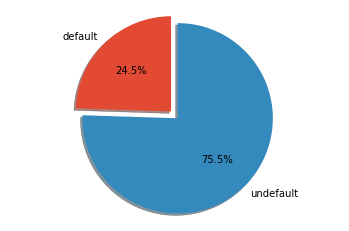

In [27]:
labels = 'default', 'undefault'
default_size = 0
undefault_size = 0
for i in Train['default_status']:
    if i == 1:
        default_size += 1
    else:
        undefault_size +=1
print(default_size)
print(undefault_size)
sizes = [(default_size / len(Train)) * 100, (undefault_size / len(Train)) * 100]
explode = (0.1, 0)  # only "explode" the 1st slice (i.e. 'default')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [28]:
42285 / 13715

3.083120670798396

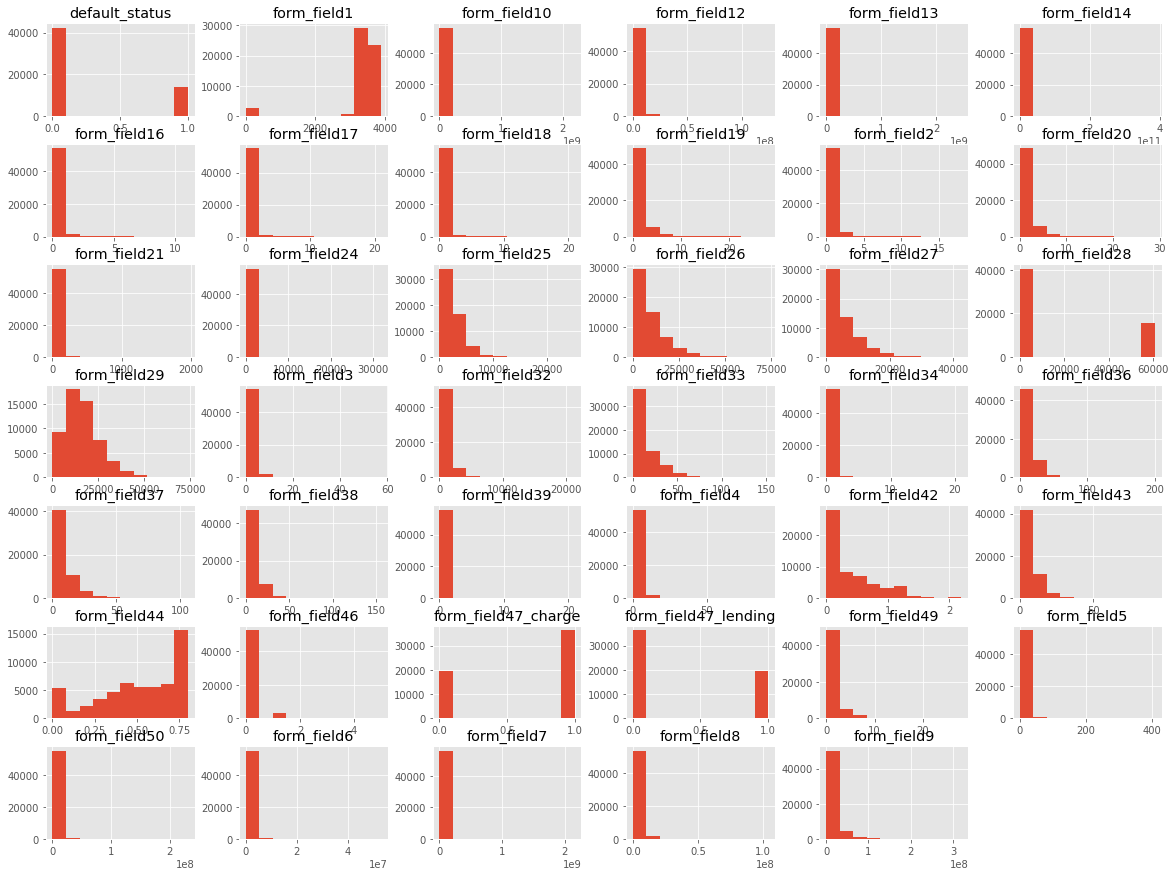

In [29]:
Train.hist(bins=10, figsize=(20, 15))
plt.show()

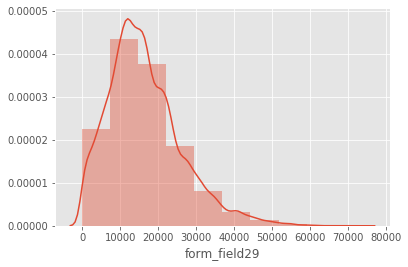

In [30]:
sns.distplot(Train['form_field29'], bins=10)

Determining correlation between target and features

In [31]:
corrMatrix = Train.corr()
corrMatrix

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,...,form_field39,form_field42,form_field43,form_field44,form_field46,form_field49,form_field50,default_status,form_field47_charge,form_field47_lending
form_field1,1.000000,-0.039225,-0.066993,-0.014034,-0.020001,0.176877,0.136908,0.260571,0.256188,0.192330,...,-0.013596,-0.407210,0.315262,0.364836,-0.015687,0.058022,0.046024,-0.161275,-0.104217,0.104217
form_field2,-0.039225,1.000000,0.125310,0.094818,0.040917,-0.156024,-0.089678,-0.178484,-0.153673,-0.118270,...,0.057931,0.127801,0.033003,-0.062640,0.093575,0.154154,-0.037873,0.230251,0.090078,-0.090078
form_field3,-0.066993,0.125310,1.000000,0.377259,0.649876,-0.142232,-0.089130,-0.222482,-0.210959,-0.141402,...,0.112386,0.436003,-0.235768,-0.092994,0.347356,0.196897,-0.039334,0.193042,0.117505,-0.117505
form_field4,-0.014034,0.094818,0.377259,1.000000,0.099723,-0.082549,-0.047385,-0.127832,-0.126682,-0.071998,...,0.114602,0.220406,-0.129540,-0.033240,0.888628,-0.020356,-0.022511,0.147164,0.072700,-0.072700
form_field5,-0.020001,0.040917,0.649876,0.099723,1.000000,-0.058861,-0.049857,-0.090279,-0.097311,-0.069967,...,0.052053,0.234396,-0.128266,-0.094995,0.094151,0.471128,-0.016463,0.088699,0.052083,-0.052083
form_field6,0.176877,-0.156024,-0.142232,-0.082549,-0.058861,1.000000,0.207628,0.522015,0.289307,0.258288,...,-0.062828,-0.240210,0.038300,0.142332,-0.073856,-0.182862,0.067735,-0.173141,-0.139697,0.139697
form_field7,0.136908,-0.089678,-0.089130,-0.047385,-0.049857,0.207628,1.000000,0.357148,0.293443,0.900845,...,-0.004871,-0.186642,0.136821,0.093068,-0.046342,-0.070685,0.063246,-0.120377,-0.057426,0.057426
form_field8,0.260571,-0.178484,-0.222482,-0.127832,-0.090279,0.522015,0.357148,1.000000,0.613027,0.472560,...,-0.082494,-0.384207,0.279087,0.137726,-0.115400,-0.170325,0.134533,-0.238201,-0.176951,0.176951
form_field9,0.256188,-0.153673,-0.210959,-0.126682,-0.097311,0.289307,0.293443,0.613027,1.000000,0.497935,...,-0.058655,-0.410594,0.497359,0.097182,-0.115411,-0.059441,0.224900,-0.228490,-0.176699,0.176699
form_field10,0.192330,-0.118270,-0.141402,-0.071998,-0.069967,0.258288,0.900845,0.472560,0.497935,1.000000,...,-0.019181,-0.281400,0.300824,0.083710,-0.068731,-0.089503,0.102554,-0.169563,-0.098030,0.098030


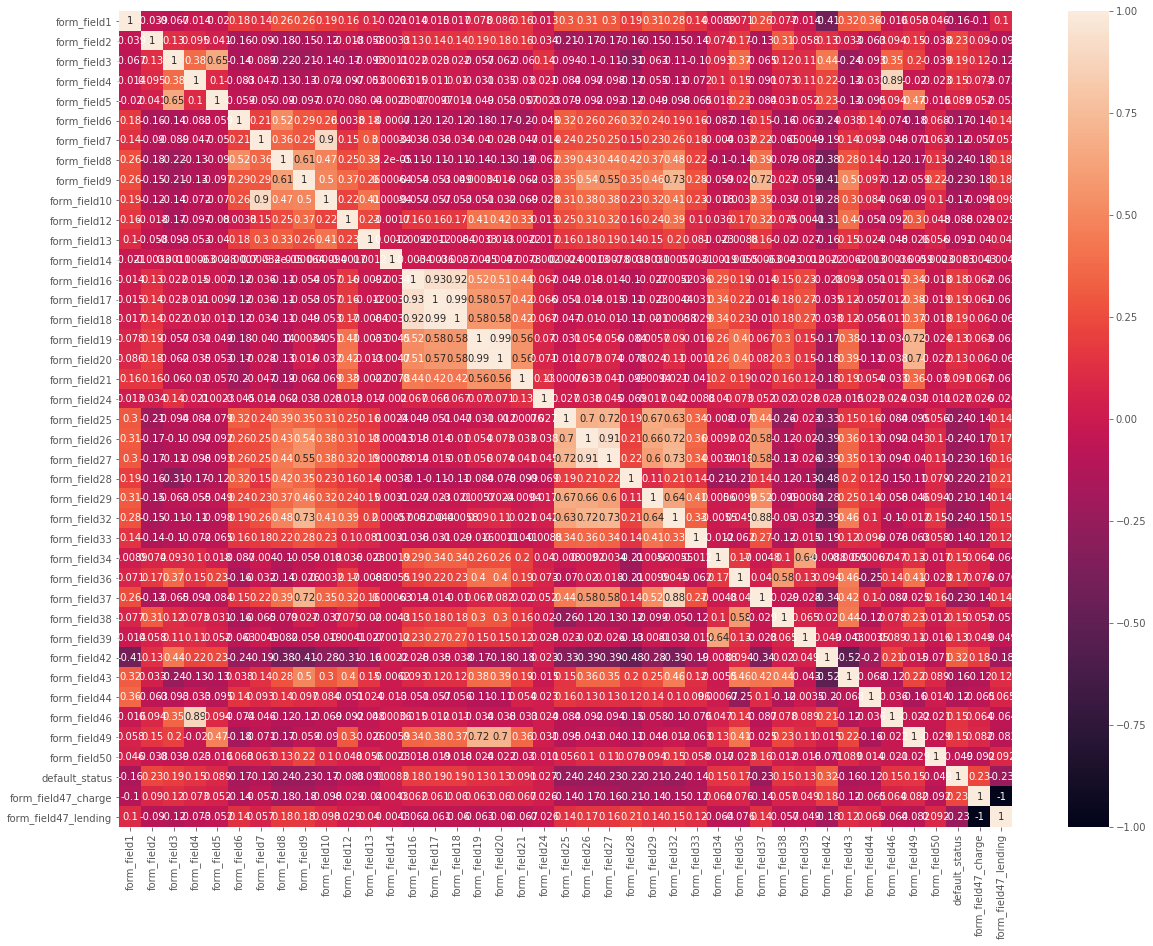

In [32]:
plt.subplots(figsize = (20, 15))
sns.heatmap(corrMatrix, annot = True)
plt.show()

Building the model

In [33]:
X = np.array(Train.drop(['default_status'], 1))
y = np.array(Train['default_status'])

In [34]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X = scaler.fit_transform(X)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

### xgboost classifier

In [37]:
xgb_clf = xgb.XGBClassifier(n_jobs = -1)
xgb_clf.fit(X_train_sc, y_train)
preds1 = xgb_clf.predict_proba(X_test_sc)
accuracy1 = xgb_clf.score(X_test_sc, y_test)
print(accuracy1)

0.81


In [38]:
auc_df = roc_auc_score(y_test, preds1[:,1])
auc_df

0.8296762051710815

### random forest classifier

In [39]:
rf_clf = RandomForestClassifier(n_jobs = -1)
rf_clf.fit(X_train_sc, y_train)
preds2 = rf_clf.predict_proba(X_test_sc)
accuracy2 = rf_clf.score(X_test_sc, y_test)
print(accuracy2)

0.80625


In [40]:
auc_rf = roc_auc_score(y_test, preds2[:,1])
auc_rf

0.8265104291588853

## using gridsearch cv

param_grid = {'n_estimators': [50, 100, 150, 200, 250, 300]}
grid = GridSearchCV(RandomForestClassifier(n_jobs=-1), param_grid= param_grid, cv=5)
grid.fit(X_train_sc, y_train)
f = grid.predict_proba(X_test_sc)[:,1]
print(grid.best_score_)
print(grid.score(X_test_sc, y_test))
print(grid.best_params_)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_mmsc = scaler.fit_transform(X_train)
X_test_mmsc = scaler.transform(X_test)

xgb_clf = xgb.XGBClassifier(n_jobs = -1)
xgb_clf.fit(X_train_mmsc, y_train)
preds1m = xgb_clf.predict_proba(X_test_mmsc)
accuracy1m = xgb_clf.score(X_test_mmsc, y_test)
print(accuracy1m)

auc_df = roc_auc_score(y_test, preds1m[:,1])
auc_df

rf_clf = RandomForestClassifier(n_jobs = -1)
rf_clf.fit(X_train_mmsc, y_train)
preds2m = rf_clf.predict_proba(X_test_mmsc)
accuracy2m = rf_clf.score(X_test_mmsc, y_test)
print(accuracy2m)

auc_rf = roc_auc_score(y_test, preds2m[:,1])
auc_rf

seed=5

In [41]:
xgb_clf = xgb.XGBClassifier(n_jobs = -1, scale_pos_weight=3, eta=0.01, n_estimators=500, max_depth=3, subsample=0.8, colsample_bytree=0.8, objective='binary:logistic', eval_metric='auc', seed=5, nthread=4)
xgb_clf.fit(X_train_sc, y_train)
predstun = xgb_clf.predict_proba(X_test_sc)
accuracytun = xgb_clf.score(X_test_sc, y_test)
print(accuracytun)

0.7427678571428571


In [42]:
auc_df = roc_auc_score(y_test, predstun[:,1])
auc_df

0.8329305357247995

seed=5

In [81]:
xgb_clf = xgb.XGBClassifier(n_jobs = -1, scale_pos_weight=3, eta=0.1, n_estimators=500, max_depth=3, subsample=0.8, colsample_bytree=0.8, objective='binary:logistic', eval_metric='auc', seed=5, nthread=4)
xgb_clf.fit(X_train_sc, y_train)
predstun2 = xgb_clf.predict_proba(X_test_sc)
accuracytun2 = xgb_clf.score(X_test_sc, y_test)
print(accuracytun2)

0.7427678571428571


In [82]:
auc_df = roc_auc_score(y_test, predstun2[:,1])
auc_df

0.8329305357247995

scaling train and test

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Train_sc = scaler.fit_transform(Train.drop(['default_status'], 1))
Test_sc = scaler.transform(Test)

xgb_clf = xgb.XGBClassifier(n_jobs = -1, scale_pos_weight=3, eta=0.01, n_estimators=500, max_depth=3, subsample=0.8, colsample_bytree=0.8, objective='binary:logistic', eval_metric='auc', seed=5, nthread=4)
xgb_clf.fit(Train_sc, Train['default_status'])
predsTest = xgb_clf.predict_proba(Test_sc)[:,1]
predsTest

default_status = predsTest

Test = Test.reset_index()
Test.head(2)

predicted_values1 = pd.DataFrame({'Applicant_ID': Test['Applicant_ID'], 'default_status': default_status})
predicted_values1

predicted_values1.to_csv('Submisson3.csv', index = False)